# Annual Cycle Departure: CDAT vs Xarray

[Jiwoo Lee](https://github.com/lee1043/) (LLNL), March 2021

In this document, annual cycle climatology fields calculated using [CDAT](https://cdat.llnl.gov/) and [Xarray](xarray.pydata.org/) are compared for checking consistency.

Useful resources:
- [Xarray instrcution from NCI data training](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_01_Xarray_access_CMIP5.html)
- [Xarray example: Calculating Seasonal Averages from Time Series of Monthly Means](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

Testing Environment:
```
conda create -y -n cdat_v8.2.1 -c conda-forge -c cdat/label/v8.2.1 cdat "libnetcdf=*=mpi_openmpi_*" "mesalib=17.3.9" "python=3.7"
conda activate cdat_v8.2.1
conda install -c conda-forge xarray 
conda install -c conda-forge netcdf4 
```

## Example input data

In [1]:
input_file = "demo_data/CMIP5_demo_data/ts_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc"

## Import libraries

In [2]:
import cdms2
import cdutil

In [3]:
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy

%matplotlib inline

## CDAT

### Load data

In [4]:
%%time

fc = cdms2.open(input_file)
dc = fc('ts', time=slice(0,48)) - 273.15  # Take first 4 years (0-48) and unit adjust (-273.15, K to C)

CPU times: user 26.1 ms, sys: 16.3 ms, total: 42.4 ms
Wall time: 44.9 ms


In [5]:
dc.shape

(48, 145, 192)

### Calculate Annual Cycle Departure

In [6]:
%%time

dc_ann = cdutil.ANNUALCYCLE(dc) 
dc_ann_ano = cdutil.ANNUALCYCLE.departures(dc)

CPU times: user 399 ms, sys: 18 ms, total: 417 ms
Wall time: 418 ms


In [7]:
print(dc_ann.shape)
print(dc_ann_ano.shape)

dc_ann.id = dc.id
dc_ann_ano.id = dc.id

time = dc_ann.getTime()

(48, 145, 192)
(48, 145, 192)


### Global area average

In [8]:
%%time

dc_ann_ts = cdutil.averager(dc_ann, axis='xy')
dc_ann_ano_ts = cdutil.averager(dc_ann_ano, axis='xy')

CPU times: user 81.9 ms, sys: 33.1 ms, total: 115 ms
Wall time: 122 ms


In [9]:
dc_ann_ts.id = dc.id
dc_ann_ano_ts.id = dc.id

dc_type_ts = {}
dc_type_ts['ANN'] = dc_ann_ts
dc_type_ts['ANN_ANO'] = dc_ann_ano_ts

### Convert data type for quick plotting

Convert array type from CDAT transient variable to Xarray data array

In [10]:
time = dc.getTime()
lat = dc.getLatitude()
lon = dc.getLongitude()

In [11]:
dc_ann_xr = xr.DataArray(dc_ann, 
                         coords=[list(time), list(lat), list(lon)], 
                         dims=["time", "lat", "lon"], 
                         name=dc.id)

dc_ann_ano_xr = xr.DataArray(dc_ann_ano, 
                             coords=[list(time), list(lat), list(lon)], 
                             dims=["time", "lat", "lon"], 
                             name=dc.id)

In [12]:
dc_type = {}
dc_type['ANN'] = dc_ann_xr
dc_type['ANN_ANO'] = dc_ann_ano_xr

### Quick plot to show the results

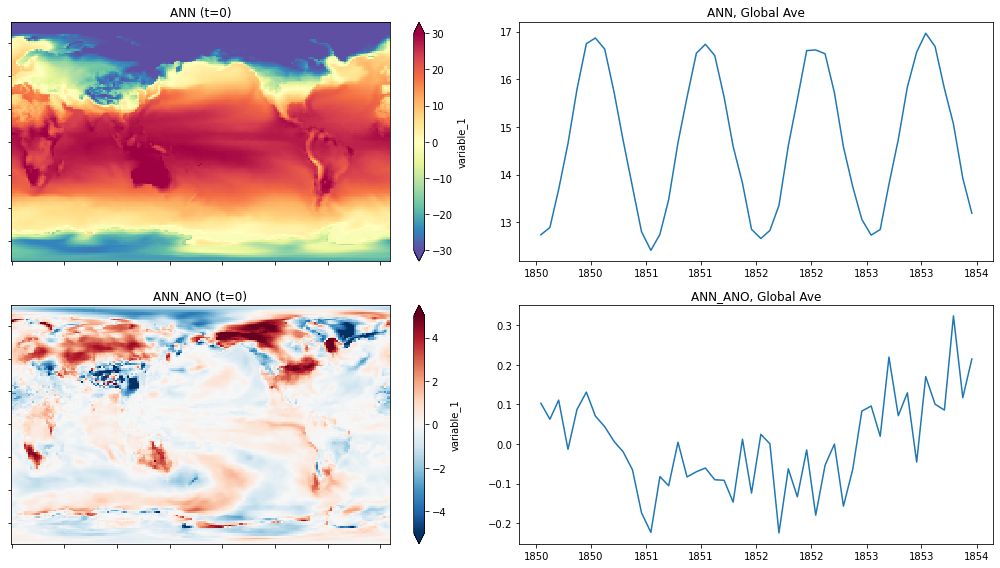

In [13]:
import datetime as dt
import matplotlib.dates as mdates

notnull = pd.notnull(dc_ann_xr[0])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

for i, data_type in enumerate(['ANN', 'ANN_ANO']):

    # Map
    if data_type in ['ANN', 'ANN_CLM']:
        cmap = 'Spectral_r'
        vmin = -30
        vmax = 30
    else:
        cmap = 'RdBu_r'
        vmin = -5
        vmax = 5
    
    dc_type[data_type][0].where(notnull).plot.pcolormesh(
        ax=axes[i,0], vmin=vmin, vmax=vmax, cmap=cmap,
        add_colorbar=True, extend='both')
    axes[i,0].set_title(data_type+' (t=0)')
    axes[i,0].set_xticklabels([])
    axes[i,0].set_yticklabels([])
    axes[i,0].set_xlabel('')
    axes[i,0].set_ylabel('')
    
    # Time series
    axes[i,1].set_title(data_type+', Global Ave')
    if data_type in ['ANN', 'ANN_ANO']:
        dates = [str(t).split(' ')[0] for t in dc_type_ts[data_type].getTime().asComponentTime()]
        x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    elif data_type in ['ANN_CLM']:
        x = list(range(1,13))
        
    axes[i,1].plot(x, dc_type_ts[data_type].tolist())

plt.tight_layout()

## Xarray

### Load data

In [14]:
%%time
fx = xr.open_dataset(input_file, decode_times=True)
dx = fx.ts[0:48] - 273.15  # Take first 4 years (0-48) and unit adjust (-273.15, K to C)

CPU times: user 298 ms, sys: 13.8 ms, total: 312 ms
Wall time: 318 ms


### Calculating Annual Cycle Departure and Climatology from Timeseries of Monthly Means

Inspired by example at http://xarray.pydata.org/en/stable/examples/monthly-means.html

In [15]:
def annual_cycle_climatology(d, weighted=True):
    if weighted:
        # Make a DataArray with the number of days in each month, size = len(time)
        month_length = d.time.dt.days_in_month

        # Calculate the weights by grouping by 'time.month'
        weights = month_length.groupby('time.month') / month_length.groupby('time.month').sum()

        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))

        # Calculate the weighted average
        return (d * weights).groupby('time.month').sum(dim='time')
    else:
        # Alternative way (https://github.com/willyhagi/climate-data-science/blob/master/Python-Scripts/annual_cycle.py)
        # Does not consider weighting
        return d.groupby('time.month').mean('time')

In [16]:
def annual_cycle_departure(d, d_ann_clim):    
    # https://github.com/willyhagi/climate-data-science/blob/master/Python-Scripts/annual_cycle.py
    d_ann_ano = d.groupby('time.month') - d_ann_clim
    return d_ann_ano

In [17]:
%%time
dx_ann_clim = annual_cycle_climatology(dx)

CPU times: user 38.2 ms, sys: 9.29 ms, total: 47.5 ms
Wall time: 56.5 ms


In [18]:
%%time
dx_ann_ano = annual_cycle_departure(dx, dx_ann_clim)

CPU times: user 41.7 ms, sys: 9.49 ms, total: 51.2 ms
Wall time: 50.6 ms


In [19]:
dx_ann = dx

In [20]:
dx_type = {}
dx_type['ANN'] = dx_ann
dx_type['ANN_ANO'] = dx_ann_ano

### Global area average

Reference: http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

In [21]:
def area_averager(d):
    weights = np.cos(np.deg2rad(d.lat))
    weights.name = "weights"
    d_weighted = d.weighted(weights)
    d_weighted_mean = d_weighted.mean(("lon", "lat"))
    return(d_weighted_mean)

In [22]:
%%time

dx_ann_ts = area_averager(dx_ann)
dx_ann_ano_ts = area_averager(dx_ann_ano)

CPU times: user 28.8 ms, sys: 4.14 ms, total: 33 ms
Wall time: 32.4 ms


In [23]:
dx_type_ts = {}
dx_type_ts['ANN'] = dx_ann_ts
dx_type_ts['ANN_ANO'] = dx_ann_ano_ts

### Quick plot to show the results

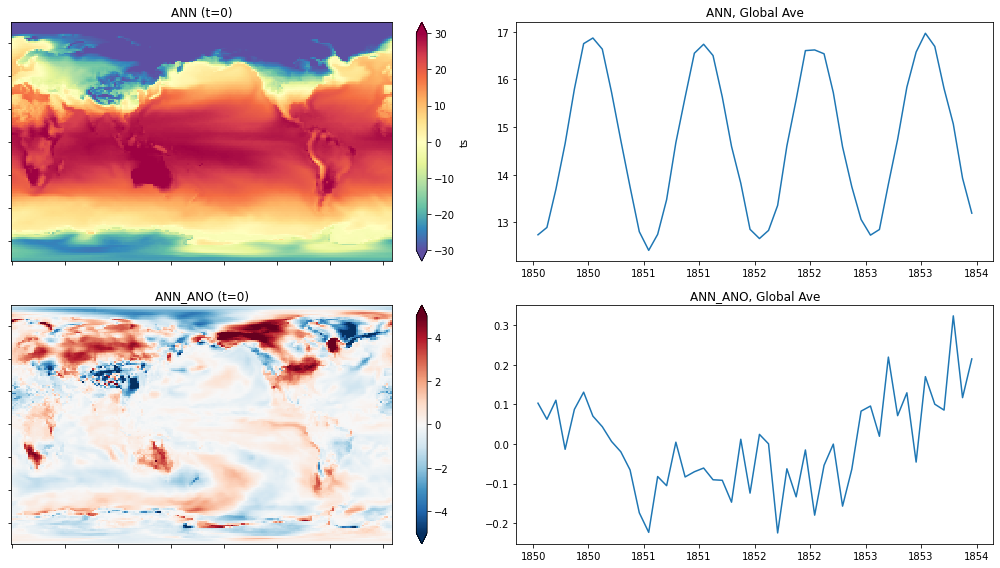

In [24]:
import datetime as dt
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

for i, data_type in enumerate(['ANN', 'ANN_ANO']):

    # Map
    if data_type in ['ANN', 'ANN_CLM']:
        cmap = 'Spectral_r'
        vmin = -30
        vmax = 30
    else:
        cmap = 'RdBu_r'
        vmin = -5
        vmax = 5
        
    d_tmp = dx_type[data_type]
    
    notnull = pd.notnull(d_tmp[0])    
    
    d_tmp[0].where(notnull).plot.pcolormesh(
        ax=axes[i,0], vmin=vmin, vmax=vmax, cmap=cmap,
        add_colorbar=True, extend='both')
    axes[i,0].set_title(data_type+' (t=0)')
    axes[i,0].set_xticklabels([])
    axes[i,0].set_yticklabels([])
    axes[i,0].set_xlabel('')
    axes[i,0].set_ylabel('')
    
    # Time series
    axes[i,1].set_title(data_type+', Global Ave')
    if data_type in ['ANN', 'ANN_ANO']:
        dates = dx_type_ts[data_type].time.values
        x = dates
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    elif data_type in ['ANN_CLM']:
        x = list(range(1,13))
        
    axes[i,1].plot(x, dx_type_ts[data_type])

plt.tight_layout()

## Check Difference between CDAT and Xarray

### Map

Text(0.5, 1.02, 'Surface Air Temperature at t=1, first Feb.')

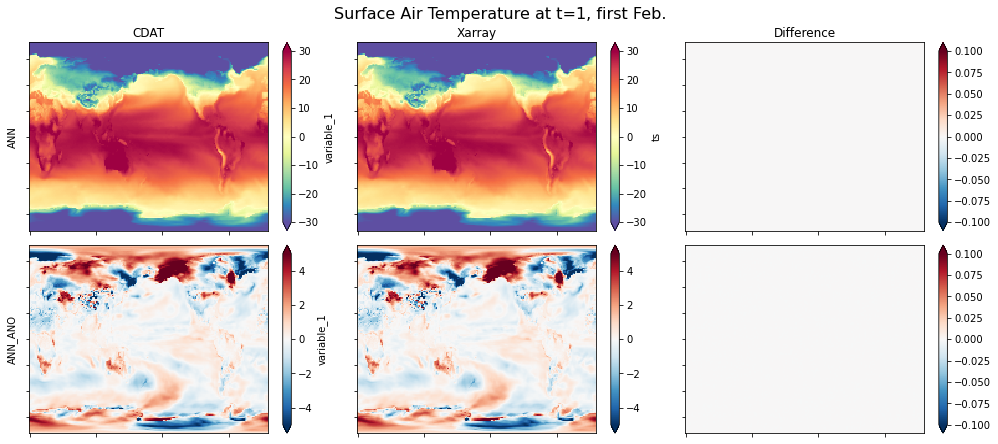

In [25]:
tstep = 1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,6))

for i, data_type in enumerate(['ANN', 'ANN_ANO']):

    # Map
    if data_type in ['ANN', 'ANN_CLM']:
        cmap = 'Spectral_r'
        vmin = -30
        vmax = 30
    else:
        cmap = 'RdBu_r'
        vmin = -5
        vmax = 5
        
    # CDAT
    dc_type[data_type][tstep].where(notnull).plot.pcolormesh(
        ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap,
        add_colorbar=True, extend='both')    
    
    # Xarray
    dx_type[data_type][tstep].where(notnull).plot.pcolormesh(
        ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap,
        add_colorbar=True, extend='both')

    # CDAT - Xarray
    (dc_type[data_type][tstep]-dx_type[data_type][tstep]).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], vmin=-0.1, vmax=.1, cmap='RdBu_r',
        add_colorbar=True, extend='both')
        
        
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

axes[0, 0].set_title('CDAT')
axes[0, 1].set_title('Xarray')
axes[0, 2].set_title('Difference')

axes[0, 0].set_ylabel('ANN')
axes[1, 0].set_ylabel('ANN_ANO')

plt.tight_layout()

fig.suptitle('Surface Air Temperature at t='+str(tstep)+', first Feb.', fontsize=16, y=1.02)

### Time Series

Text(0.5, 1.02, 'Surface Air Temperature Global Area Average')

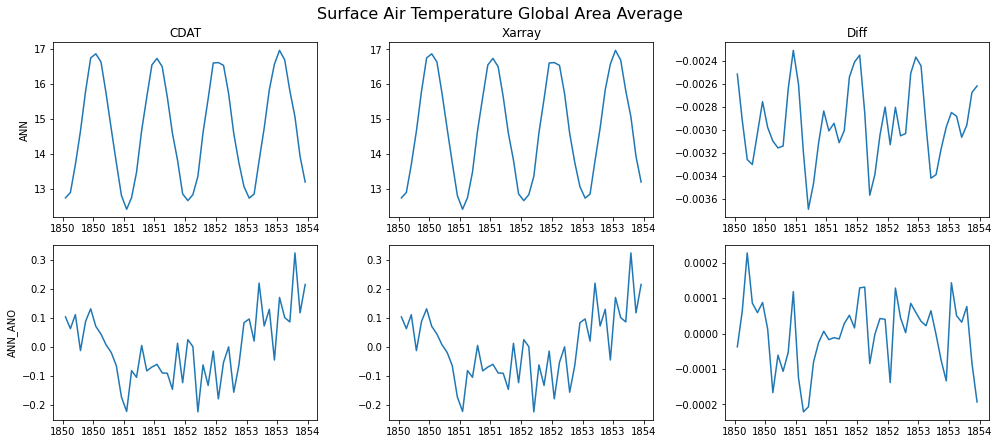

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,6))

for i, data_type in enumerate(['ANN', 'ANN_ANO']):
    
    for j, data_from in enumerate(['CDAT', 'Xarray', 'Diff']):  
               
        if data_type in ['ANN', 'ANN_ANO']:
            dates = dx_type_ts[data_type].time.values
            x = dates
            axes[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        elif data_type in ['ANN_CLM']:
            x = list(range(1,13))
        
        # Time series
        if data_from == "CDAT":
            y = dc_type_ts[data_type].tolist()
        elif data_from == "Xarray":
            y = dx_type_ts[data_type].values.tolist()
        elif data_from == "Diff":
            y = list(dc_type_ts[data_type] - dx_type_ts[data_type])
                   
        axes[i,j].plot(x, y)
        
        if j == 0:
            axes[i,j].set_ylabel(data_type)
        if i == 0:
            axes[i,j].set_title(data_from)
        
fig.tight_layout()

fig.suptitle('Surface Air Temperature Global Area Average', fontsize=16, y=1.02)